# Data Visualization

This notebook is a look at visualizing different aspects of my dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text as sql

import os
pg_pass = os.environ['BEER_DB']
engine = create_engine(pg_pass)

In [2]:
def run_query(query,params={}):
    return pd.read_sql(sql(query), 
                con=engine, 
                params=params)

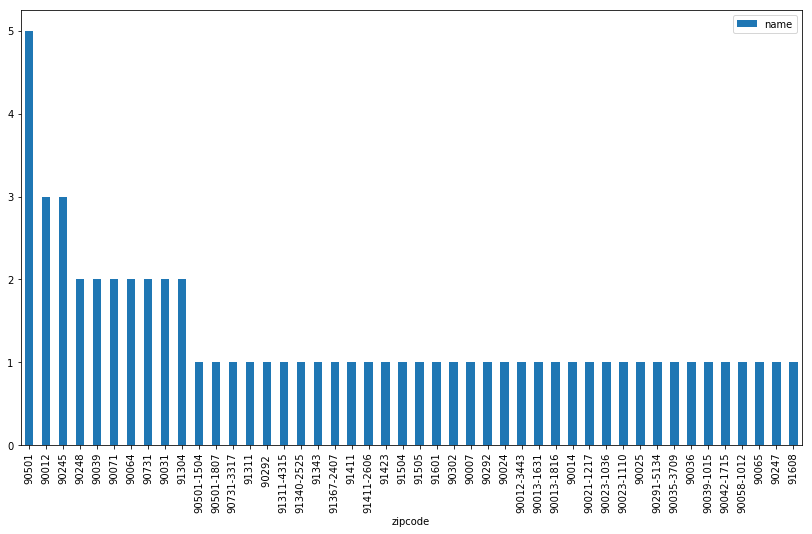

In [3]:
# Grab Breweries in LA
in_la ="""
SELECT 
name, zipcode 
FROM breweries 
WHERE CAST(
    split_part(zipcode,'-', 1) AS INTEGER
) IN (
    90001,90021,90044,90077,90502,
    91330,91504,90002,90023,90045,
    90089,90710,91331,91505,90003,
    90024,90046,90094,90717,91335,
    91601,90004,90025,90047,90095,
    90731,91340,91602,90005,90026,
    90048,90210,90732,91342,91604,
    90005,90027,90049,90211,90732,
    91343,91605,90006,90028,90056,
    90212,90744,91344,91606,90007,
    90029,90057,90230,90810,91345,
    91607,90008,90031,90058,90232,
    91040,91352,91608,90010,90032,
    90059,90245,91042,91356,90011,
    90033,90061,90247,91214,91364,
    90012,90034,90062,90248,91303,
    91367,90013,90035,90063,90272,
    91304,91401,90014,90036,90064,
    90290,91306,91402,90015,90037,
    90065,90291,91307,91403,90016,
    90038,90066,90292,91311,91405,
    90017,90039,90067,90293,91316,
    91406,90018,90041,90068,90302,
    91324,91411,90019,90042,90069,
    90402,91325,91423,90020,90043,
    90071,90501,91326,91436
);"""

run_query(in_la).groupby("zipcode").count().sort_values(
    by="name", ascending=False).plot(kind="bar",figsize=(14,8))

c:\python36\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'style' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


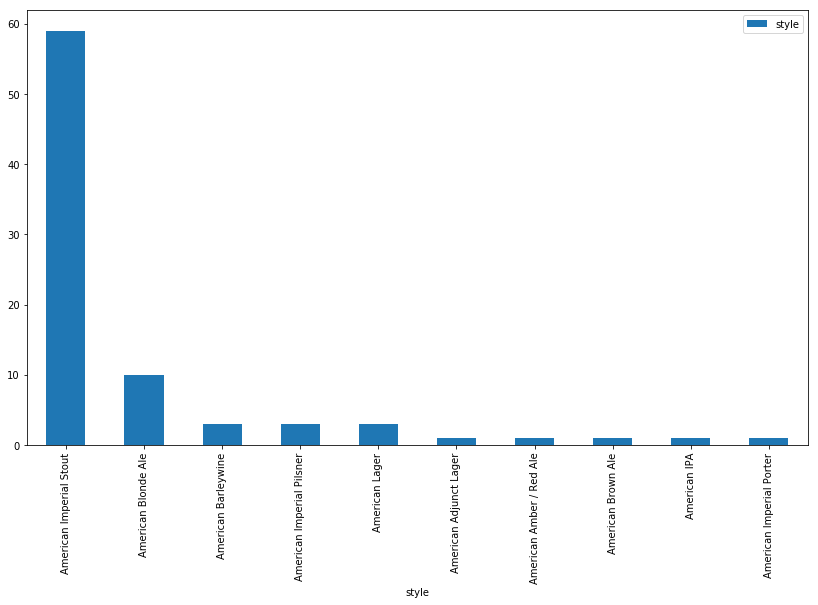

In [4]:
# Grab beers, brewery name and style from "The Bruery"
bruery_beers = """
SELECT 
beers.name AS beer_name, 
breweries.name AS brewery_name, 
styles.name AS style
FROM beers,breweries,styles 
WHERE beers.brewery_id = breweries.id 
AND beers.style_id = styles.id 
AND breweries.name 
LIKE '%Bruery%';
"""
run_query(bruery_beers).groupby(["style"])[["style"]].count()[0:10].sort_values(
    by="style", ascending=False).plot(kind="bar", figsize=(14,8))

In [5]:
# Grab beers, brewery name and style from Breweries in LA
la_beer_styles = """
SELECT 
breweries.name AS brewery_name, 
styles.name AS style,
beers.name AS beer_name
FROM beers,breweries, styles 
WHERE 
beers.brewery_id = breweries.id 
AND beers.style_id = styles.id 
AND CAST(split_part(breweries.zipcode,'-', 1) AS INTEGER) 
in (
    90001,90021,90044,90077,90502,
    91330,91504,90002,90023,90045,
    90089,90710,91331,91505,90003,
    90024,90046,90094,90717,91335,
    91601,90004,90025,90047,90095,
    90731,91340,91602,90005,90026,
    90048,90210,90732,91342,91604,
    90005,90027,90049,90211,90732,
    91343,91605,90006,90028,90056,
    90212,90744,91344,91606,90007,
    90029,90057,90230,90810,91345,
    91607,90008,90031,90058,90232,
    91040,91352,91608,90010,90032,
    90059,90245,91042,91356,90011,
    90033,90061,90247,91214,91364,
    90012,90034,90062,90248,91303,
    91367,90013,90035,90063,90272,
    91304,91401,90014,90036,90064,
    90290,91306,91402,90015,90037,
    90065,90291,91307,91403,90016,
    90038,90066,90292,91311,91405,
    90017,90039,90067,90293,91316,
    91406,90018,90041,90068,90302,
    91324,91411,90019,90042,90069,
    90402,91325,91423,90020,90043,
    90071,90501,91326,91436
);
"""
levels = run_query(la_beer_styles)

# Sunburst Charts

In [6]:
# https://stackoverflow.com/a/46790802/2548452
def sunburst(nodes, total=np.pi * 2, offset=0, level=0, ax=None):
    ax = ax or plt.subplot(111, projection='polar')
    if level == 0 and len(nodes) == 1:        
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels = []
        widths = []
        local_offset = offset
        for label, value, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge')
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()

In [7]:
def multi_level_struct(top_level, df, columns):
    top_level_list = []
    for i,column in enumerate(columns):
        counts = df[column].value_counts()
        indices = counts.index
        for j,count in enumerate(counts):
            if i == 0:
                top_level_list.append((indices[j], count,[]))
            if i == 1:
                for brewery in top_level_list:
                    lvl_2s = df[df[columns[1]] == indices[j]].sort_values(by=columns[0])
                    current_lvl_2 = ""
                    lvl_2_count = 0
                    lvl_2_3s = []
                    for lvl_2 in lvl_2s.values:
                        if lvl_2[0] == brewery[0]:
                            lvl_2_count+= 1
                            current_lvl_2 = lvl_2[1]
                            lvl_2_3s.append((lvl_2[2], 1, []))
                    if current_lvl_2 != "":
                        lvl_2_tuple = (current_lvl_2, lvl_2_count, lvl_2_3s)
                        brewery[2].append(lvl_2_tuple)
    
    return [(top_level, df.count()[0], top_level_list)]

These are the varieties of beers within 3 miles (as the crow flies) of General Assembly in Santa Monica

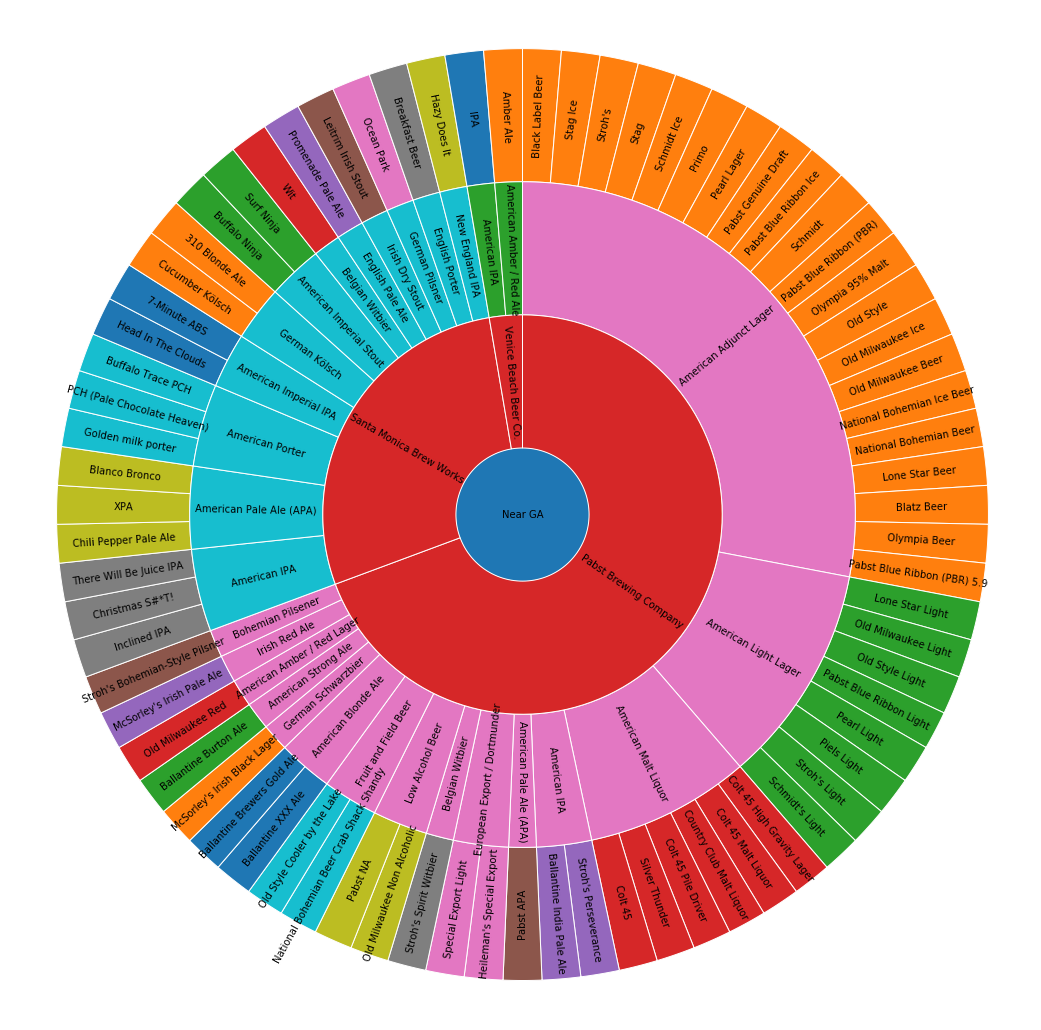

In [42]:
# Grab the beers with styles from breweries 3 miles (rounded) AS the crow flies
# Near Santa Monica

near_ga = """
SELECT
breweries.name AS brewery_name,
styles.name as style,
beers.name AS beer_name
FROM beers, breweries, styles
WHERE beers.brewery_id = breweries.id
AND beers.style_id = styles.id 
AND breweries.position IS NOT NULL
AND ST_DWithin(
    ST_GeomFromText('POINT(34.01080683333333 -118.4922238333333)', 4326),
    ST_GeomFromText(ST_AsText(position),4326), 3/57.884
);
"""
ga_levels = run_query(near_ga)
plt.figure(figsize=(28,18))
sunburst(multi_level_struct("Near GA", ga_levels, ["brewery_name","style","beer_name"]))

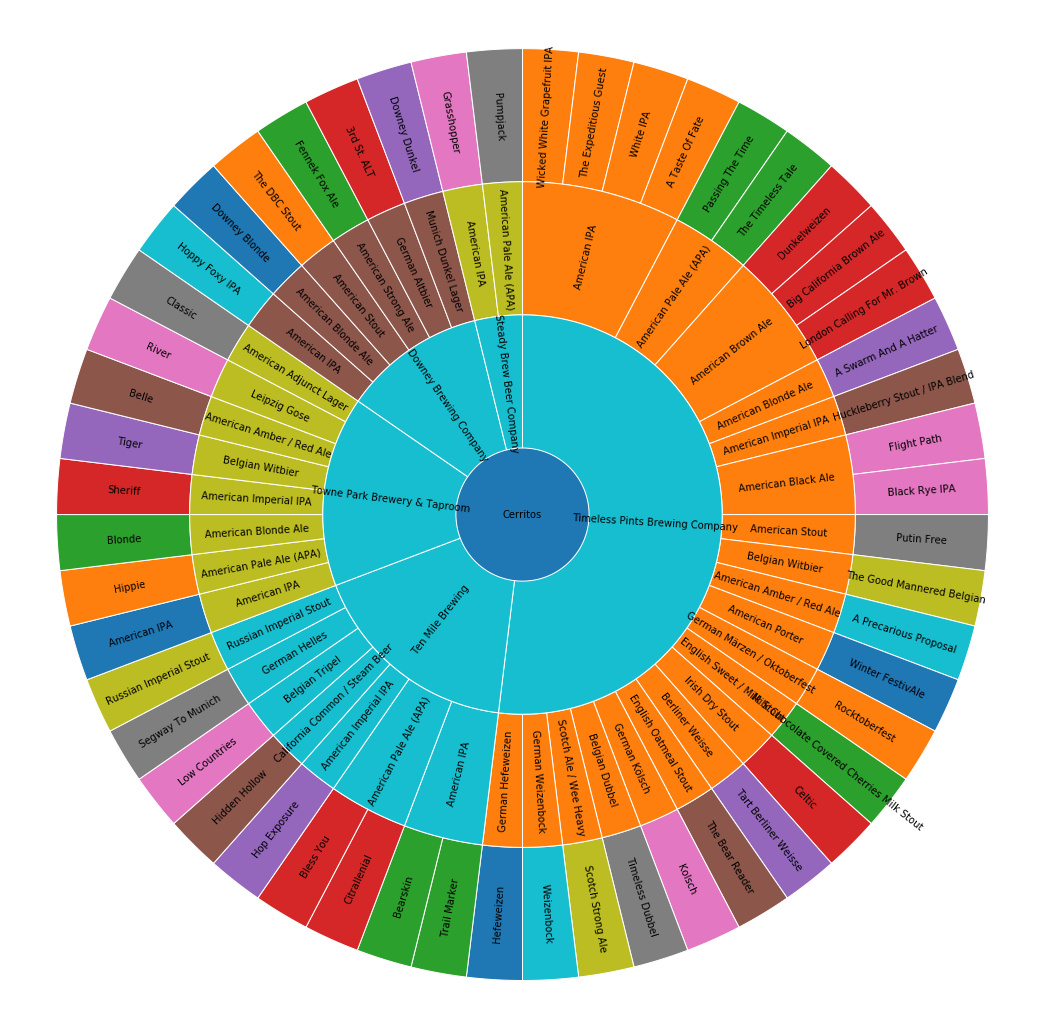

In [48]:
near_cerritos = """
SELECT
breweries.name AS brewery_name,
styles.name as style,
beers.name AS beer_name
FROM beers, breweries, styles
WHERE beers.brewery_id = breweries.id
AND beers.style_id = styles.id 
AND breweries.position IS NOT NULL
AND ST_DWithin(
    ST_GeomFromText('POINT(33.8548734 -118.06258630000002)', 4326),
    ST_GeomFromText(ST_AsText(position),4326), 7/57.884
);
"""
cerritos_levels = run_query(near_cerritos)
plt.figure(figsize=(28,18))
sunburst(multi_level_struct("Cerritos", cerritos_levels, ["brewery_name","style","beer_name"]))